## <font color = "red">初期設定</font>

In [3]:
# Google Colaboratory上からGoogle Drive上のファイルにアクセスできるようにする
from google.colab import drive
drive.mount('/content/drive')

# ~/.kaggleディレクトリを作成し、ここへDrive上のkaggle.jsonをコピーしてくる
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定（所有者⇒フル権限・その他無し）
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
#ライブラリのインストール
!pip install kaggle                     #kaggleAPI利用用

!pip install lightgbm==3.3.1            #kaggle版のlightgbmとバージョン条件を合わせる

!pip install japanize-matplotlib        #matplotlibの日本語対応
!pip install optuna                     #最適化用

     |████████████████████████████████| 2.0 MB 5.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 4.1 MB 5.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=7558e16980a24f14e3e8b27f889bffa1227f9d0ac7392c9052e15d7bbe8fbe15
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 83.3 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 112 kB 75.7 MB/s 
     |████████████████████████████████| 149 kB 82.2 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  C

In [5]:
%%time
#kaggleから"ubiquant-parquet"を保存
!kaggle datasets download -d robikscube/ubiquant-parquet -p /content

100% 12.5G/12.5G [01:46<00:00, 96.1MB/s]
100% 12.5G/12.5G [01:46<00:00, 126MB/s] 
CPU times: user 1.4 s, sys: 283 ms, total: 1.68 s
Wall time: 1min 46s


In [6]:
%%time
#解凍用パス
import zipfile
with zipfile.ZipFile('/content/ubiquant-parquet.zip') as existing_zip:
    existing_zip.extractall('/content')


CPU times: user 2min 28s, sys: 18.8 s, total: 2min 46s
Wall time: 3min 8s


In [7]:
#ライブラリのインポート
import glob
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import optuna

#lgb用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

#警告を非表示
import warnings
warnings.simplefilter('ignore')

import time
#seaborn 可視化用
%matplotlib inline

#モデル保存用
import pickle

#省略表示のキャンセル
pd.set_option('display.max_columns', 10000000)
pd.set_option('display.max_rows', 10000000)

## <font color = "red">parquet datasetsの読み込み</font>

In [8]:
%%time
#Pathの設定
DATA_PATH = '/content/'

#%%time
train = pd.read_parquet(DATA_PATH + 'train_low_mem.parquet') 

CPU times: user 11.4 s, sys: 57.8 s, total: 1min 9s
Wall time: 5.64 s


In [113]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_200,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,f_210,f_211,f_212,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_258,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,0.004936,0.284220,0.502155,-0.287932,-1.169338,-0.267310,-0.574423,-0.771869,1.012212,-1.230507,1.785726,-2.090686,0.325659,-0.877769,1.048786,0.131774,-0.349609,-1.813385,0.099226,-0.241020,1.604571,0.003637,-0.902062,0.221581,0.610063,-0.738558,2.097248,-0.913877,-0.293838,-0.037989,0.685313,0.000000,0.414692,-0.469456,-1.085879,-0.106443,0.059437,0.483066,1.189394,0.506955,0.754617,0.317529,-0.183254,5.163592,0.677065,-0.440767,0.631208,-1.845506,0.227782,0.841269,0.667432,-0.854111,-0.170443,-0.119705,-0.504936,0.662736,1.933138,-0.812392,0.072803,-0.778987,-0.553666,-0.032761,-0.619364,-1.424479,0.148335,0.257903,0.735336,0.563988,-0.272209,1.190193,-0.101368,1.334254,0.191304,0.631093,1.010617,0.161823,0.609280,-0.219488,-0.013066,1.506267,-1.319729,0.448331,-0.635492,-0.075377,1.033415,-0.663835,0.139904,0.186302,0.593067,-0.301417,0.666485,0.713296,1.020150,0.879753,-1.096843,-0.211008,-0.117488,-0.778925,0.065995,0.229715,0.435220,1.232932,-0.865958,0.062334,0.382317,-1.314973,0.786547,0.770604,-0.871134,0.583681,0.115572,0.209563,0.325480,0.469299,0.0,-0.731537,-0.249460,-0.050556,-1.232234,-0.790321,0.493377,0.357890,-0.381520,0.176383,0.747842,-0.741808,0.089653,1.080129,1.137773,1.199654,0.030609,-0.356244,0.247752,1.395867,0.961788,0.078155,-1.163461,0.707686,0.256030,-0.026309,0.329076,0.196018,0.653437,0.069232,0.907741,-0.350672,-1.170469,0.659417,0.937634,0.482803,-0.094882,0.317427,0.126840,0.892235,-1.198890,-0.315441,0.704042,-0.017697,-0.513040,-0.362513,1.000001,2.265769,0.360068,0.054464,1.640008,-1.000001,0.877145,0.368121,0.991219,-1.224520,-1.209457,-0.879788,1.000001,0.035147,0.693420,0.307024,0.143851,0.727827,1.220567,-0.939815,-0.106957,0.000000,-0.569376,0.187862,-0.386533,-0.452415,0.269767,-0.565408,-0.262123,-1.473739,0.0,0.428188,1.739962,0.941326,-0.729755,-0.533060,-0.983522,-0.043163,-0.225960,-0.008302,-0.448114,0.551247,-0.153030,-2.292569,0.186686,-0.443145,0.121193,0.787804,1.996148,-1.286072,-0.157245,1.019170,0.693566,0.797566,-0.192656,0.22274,0.921590,-0.171435,0.021656,1.152991,0.690099,3.251369,0.992130,-0.779892,-0.546556,-0.379102,1.896456,-0.732326,-0.113788,1.127601,-0.

In [ ]:
"""
#trainのデータ数制限をする場合、こちらを参照
use_feature_cols = [f'f_{i}' for i in range(150)]
print(use_feature_cols)
train = train[['row_id', 'time_id','investment_id', 'target'] + use_feature_cols]

feature_cols = [f'f_{i}' for i in range(300)]
df = pd.DataFrame(np.arange(3020).reshape(10, 302),
                 columns = [['target', 'investment_id'] + feature_cols],
                 index=['row0', 'row1', 'row2', 'row3', 'row4', 'row5', 'row6', 'row7', 'row8', 'row9'])
df
"""

['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37', 'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46', 'f_47', 'f_48', 'f_49', 'f_50', 'f_51', 'f_52', 'f_53', 'f_54', 'f_55', 'f_56', 'f_57', 'f_58', 'f_59', 'f_60', 'f_61', 'f_62', 'f_63', 'f_64', 'f_65', 'f_66', 'f_67', 'f_68', 'f_69', 'f_70', 'f_71', 'f_72', 'f_73', 'f_74', 'f_75', 'f_76', 'f_77', 'f_78', 'f_79', 'f_80', 'f_81', 'f_82', 'f_83', 'f_84', 'f_85', 'f_86', 'f_87', 'f_88', 'f_89', 'f_90', 'f_91', 'f_92', 'f_93', 'f_94', 'f_95', 'f_96', 'f_97', 'f_98', 'f_99', 'f_100', 'f_101', 'f_102', 'f_103', 'f_104', 'f_105', 'f_106', 'f_107', 'f_108', 'f_109', 'f_110', 'f_111', 'f_112', 'f_113', 'f_114', 'f_115', 'f_116', 'f_117', 'f_118', 'f_119', 'f_120', 'f_121', 'f_122', 'f

"\nfeature_cols = [f'f_{i}' for i in range(300)]\ndf = pd.DataFrame(np.arange(3020).reshape(10, 302),\n                 columns = [['target', 'investment_id'] + feature_cols],\n                 index=['row0', 'row1', 'row2', 'row3', 'row4', 'row5', 'row6', 'row7', 'row8', 'row9'])\ndf\n"

# <font color = "red">lightgbm_standard モデル作成</font>

In [9]:
%%time
#lightgbm用のデータセット作成
train.drop(['row_id', 'time_id'], axis=1, inplace=True)


df_train, df_val =train_test_split(train, test_size=0.2)
del train

col = "target"
train_y = df_train[col]
train_x = df_train.drop(col, axis=1)
del df_train

val_y = df_val[col]
val_x = df_val.drop(col, axis=1)
del df_val

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(val_x, val_y)

CPU times: user 7.97 s, sys: 5.78 s, total: 13.8 s
Wall time: 12.6 s


In [10]:
print(val_x.shape)
print(train_x.shape)
val_x.head()

(628282, 301)
(2513128, 301)


,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_200,f_201,f_202,f_203,f_204,f_205,f_206,f_207,f_208,f_209,f_210,f_211,f_212,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_258,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
369735,2864,-0.714254,0.403786,-0.577341,-0.675052,-0.107169,0.159885,-0.555024,-0.431471,0.150143,0.361517,0.601884,0.653874,0.348038,-0.428120,0.436170,0.239338,-0.251605,-0.530236,-0.549686,0.122038,1.235710,-0.797036,0.291923,-0.490174,0.392813,0.236429,-0.964331,0.721030,-1.036808,-0.088006,-0.058223,-0.486091,-0.692766,0.303746,2.034641,0.051499,0.506659,0.708316,-0.212052,0.244453,0.786480,1.192079,0.074266,0.018200,0.534778,1.351751,0.878502,0.328585,1.277142,0.570123,0.626905,-0.263027,0.378031,2.157885,-0.048200,-0.373762,0.533841,-1.823767,0.122244,-0.362379,1.202811,0.824063,-0.192685,-0.117760,0.074847,0.538232,-0.530099,1.128613,-0.254939,-0.451932,0.848966,-0.364364,-0.306281,0.871747,0.112816,-0.650450,-0.081317,-0.229260,-0.028948,-0.173640,0.274767,0.855151,1.140856,0.159683,0.351252,0.663574,0.459245,-0.208323,-0.260105,0.710940,-0.467949,-0.578184,-0.609139,-0.118227,0.741710,-0.445874,0.206245,-0.432543,-0.720375,-0.387041,0.851308,0.065914,0.665393,0.041481,0.443640,-0.741456,0.241569,-0.597406,0.078807,0.746790,0.556942,-1.940369,-0.917617,-0.280173,1.423807,-0.780239,-0.012237,0.212860,2.015572,-0.056526,0.591560,-0.610567,-1.329244,0.012680,0.000000,0.148513,-0.538808,0.041890,-0.225392,-0.577822,0.403739,-0.073838,-0.966778,-0.190562,-0.167548,-0.056633,0.099779,-0.241321,1.289175,0.643266,0.683695,0.786839,0.284503,1.129502,0.977689,0.078811,-0.054009,-0.584131,0.459833,-1.394043,0.365905,-0.456997,0.734653,0.078811,-0.480763,-0.093638,0.441392,0.378761,0.899157,-0.056656,0.422473,-0.190691,0.969931,1.146848,1.096483,-0.181048,0.728331,-0.552027,1.053555,-0.627642,0.000000,0.597434,-0.160321,0.292318,-0.291116,0.000000,-1.069476,1.016359,1.663434,-0.148870,-0.671119,-0.959788,0.000000,0.023066,0.410818,1.064128,-0.189548,1.041739,-0.054314,0.345706,0.695275,0.303727,0.591135,-0.316863,0.681293,-0.897967,-0.480502,-0.388174,-0.284801,-1.086105,0.999999,-0.294345,0.277566,0.661564,0.497846,-0.441895,-0.459443,0.417260,-0.638611,-0.788845,-0.087585,0.524994,0.960763,-0.548955,-0.483282,-0.985997,0.962996,0.295053,-0.591492,0.399666,0.505398,0.733140,-0.634396,0.401168,0.086096,0.392681,-0.514310,0.813935,0.066298,1.205917,-1.125379,0.088925,1.272077,-0.501505,1.058610,-1.382729,0.049303,-0.178149,0.495563,-0.722366,-0.608361,0.1501

In [11]:
%%time
#lgbの実行（単純系）
params = {
    "objective": "regression",
    "metrics": "rmse",
    "random_seed":1234,
    "learning_rate":0.01,
    "n_estimators":1000,
    "verbose": -1
}
categorical_features = ["investment_id"]

model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                  num_boost_round=10000,
                  early_stopping_rounds=100,
                  verbose_eval=-1,
                  categorical_feature = categorical_features)
va_pred = model.predict(val_x)
#score = mae(val_y, va_pred)
#print(f'mae:{score:.6f}')

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.90939
CPU times: user 2h 16min 8s, sys: 4.76 s, total: 2h 16min 12s
Wall time: 3min 37s


In [12]:
y_pred = model.predict(val_x)
np.sqrt(np.power(val_y - y_pred, 2).mean())


0.9093901354020341

In [116]:
#学習済みモデルの保存
file = '/content/drive/MyDrive/kaggle/models/UMP_model001.pkl'
pickle.dump(model, open(file, 'wb'))

In [13]:
pd.DataFrame(model.feature_importance(), index=val_x.columns, columns=["importance"]).sort_values("importance", ascending=False)

,importance
investment_id,21826
f_231,290
f_153,279
f_225,262
f_179,175
f_118,174
f_22,155
f_78,152
f_65,138
f_130,136


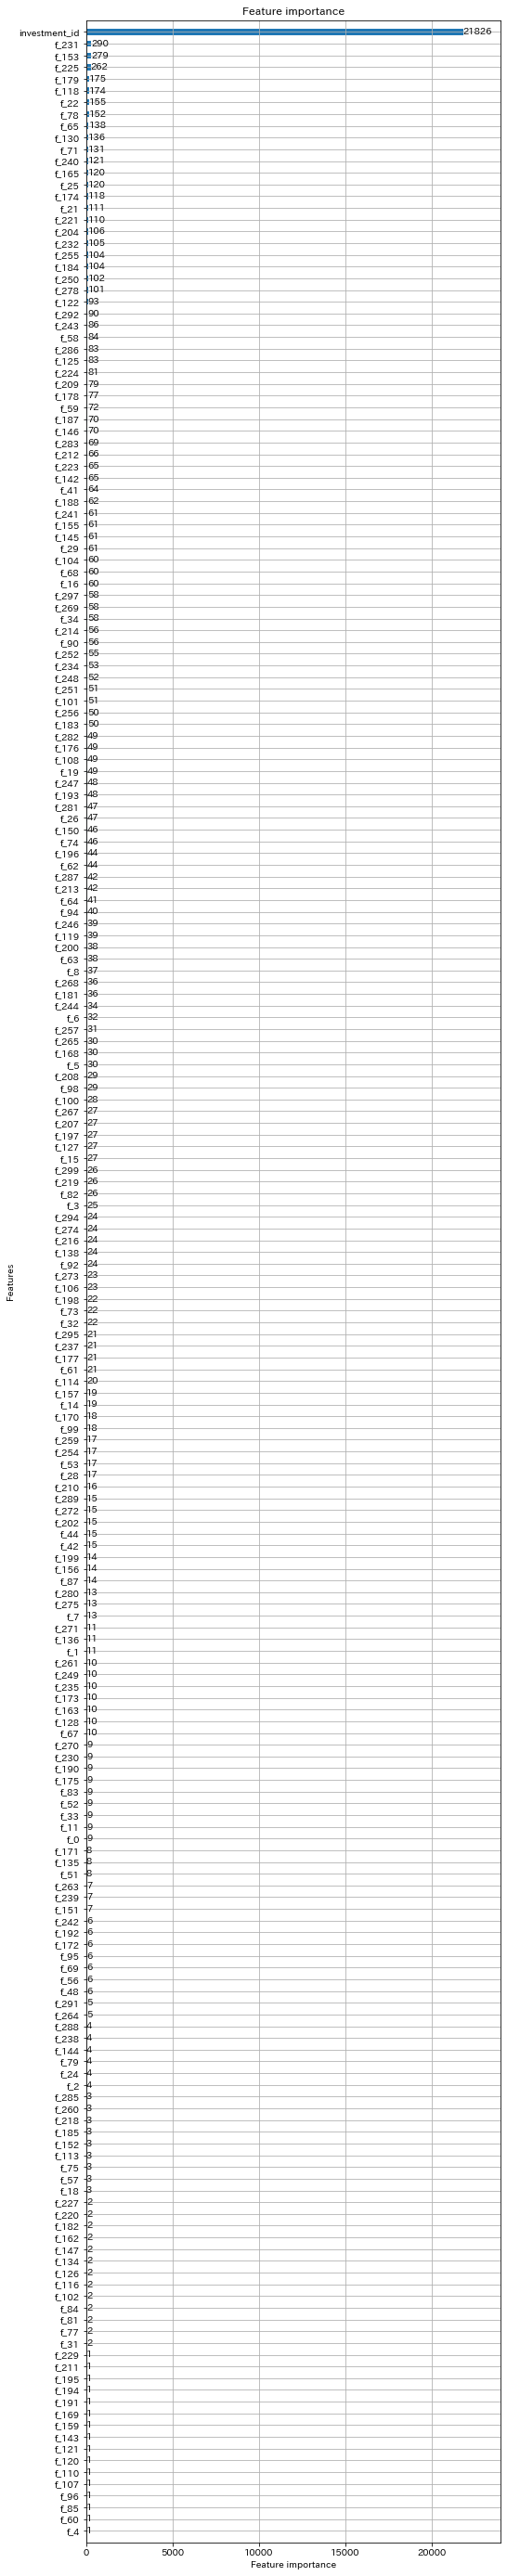

In [15]:
#要素の重要度を可視化
lgb.plot_importance(model, height = 0.5, figsize = (8,50))

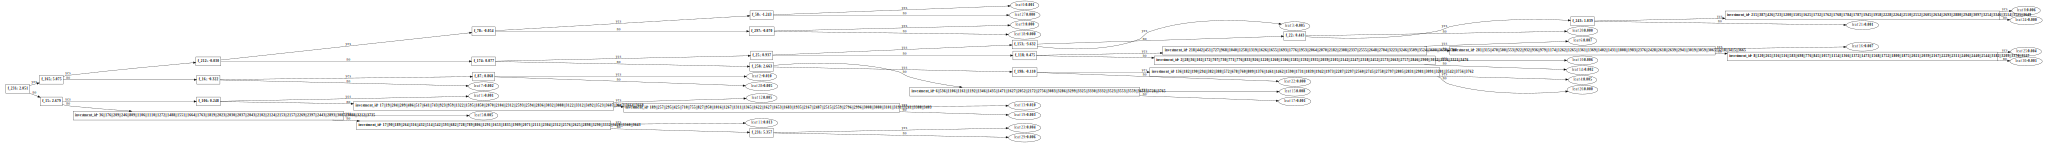

In [16]:
#要素の重要度を樹形図で表示
lgb.create_tree_digraph(model, 1)

# <font color = "red">KaggleDatasetへアップロード</font>

In [106]:
#currypanさんブログ記載の、colab⇒kaggle datasetへのアップロードのセットを改良
#url{https://zenn.dev/currypurin/scraps/e01410c6529e8e0d3af9}
UPLOAD_DIR = '/content/drive/MyDrive/kaggle/models/'  #modelの格納フォルダを指定
EX_NO = 'UMP-models'  # 実験番号などを入れる、folderのpathにする。"_"は入らないため注意（errorも返さない。）
USERID = 'zin371'


def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}'

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR + 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    dataset_list = !kaggle datasets list -m
    dataset_list = '.'.join(dataset_list)   #自身のdataset一式を一要素リストとして取得
    
    # データセットがない場合
    if EX_NO not in dataset_list:
        !kaggle datasets create -p '/content/drive/MyDrive/kaggle/models/'
        print('new upload')
    # データセットがある場合
    else:
        !kaggle datasets version -p '/content/drive/MyDrive/kaggle/models/' -m 'Update' -d -t
        print('update')

In [117]:
dataset_upload()

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file UMP_model001.pkl
100% 10.1M/10.1M [00:01<00:00, 5.84MB/s]
Upload successful: UMP_model001.pkl (10MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/zin371/UMP-models
update
